228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.3149 - loss: 1.5768 - val_accuracy: 0.4918 - val_loss: 1.2872
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.5534 - loss: 1.1700 - val_accuracy: 0.5300 - val_loss: 1.1987
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.5955 - loss: 1.0755 - val_accuracy: 0.5518 - val_loss: 1.1465
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.6434 - loss: 0.9881 - val_accuracy: 0.5627 - val_loss: 1.1207
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.6614 - loss: 0.9448 - val_accuracy: 0.5913 - val_loss: 1.0720
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.3717 - loss: 2.1445 - val_accuracy: 0.4973 - val_loss: 1.3

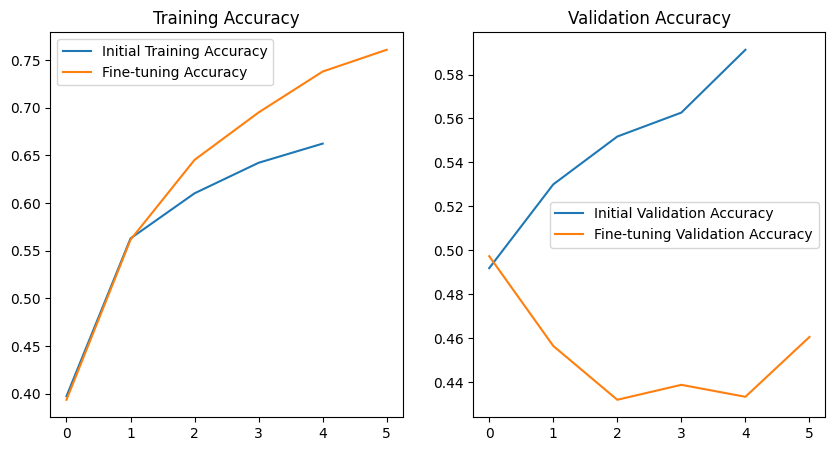

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

# Load the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

# Prepare the dataset
batch_size = 32
img_size = (224, 224)

train_dataset = image_dataset_from_directory(data_dir,
                                             validation_split=0.2,
                                             subset="training",
                                             seed=123,
                                             image_size=img_size,
                                             batch_size=batch_size)

val_dataset = image_dataset_from_directory(data_dir,
                                           validation_split=0.2,
                                           subset="validation",
                                           seed=123,
                                           image_size=img_size,
                                           batch_size=batch_size)

# Preprocess the dataset
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
# Reduces the spatial dimensions of the feature maps produced by MobileNetV2 (e.g., (7, 7, 1280) for a 224×224 input image) to a single value per channel.
# Produces a compact feature vector of size (batch_size, 1280), where 1280 is the number of output channels of MobileNetV2.

global_avg_pooling = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(5, activation='softmax')  # 5 classes in the flowers dataset

model = models.Sequential([
    base_model,
    global_avg_pooling,
    output_layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
initial_epochs = 5
history = model.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs)

# Fine-tune the model (unfreeze some layers in the base model)
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers from index 100 onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, validation_data=val_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1])

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy after Fine-tuning: {accuracy:.2f}")

# Plot accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Initial Training Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuning Accuracy')
plt.legend()
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='Initial Validation Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.show()
